# Basic Classifier using InferDotNet

## Introduction

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from scipy import special
import numpy as np

In [2]:
def cdf(x,mu,sig):
    return 0.5*(1+special.erf((x-mu)/(sig*np.sqrt(2))))

### Config

In [3]:
data_dir = Path('../data')
input_dataset = data_dir/'iris.csv'
output_dataset = data_dir/'iris-one-feature.csv'
model_output = data_dir/'model-output.csv'

### Data Acquisition

In [4]:
df = pd.read_csv(input_dataset)

# We subset the data to only have 
df_2_class = df[df['class'].\
    isin(['Iris-virginica', 'Iris-setosa'])].copy()

<AxesSubplot:xlabel='sepallength', ylabel='sepalwidth'>

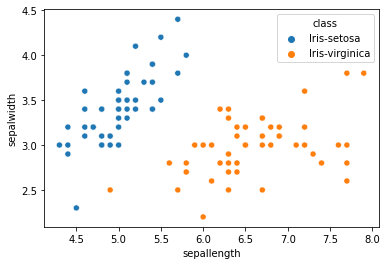

In [5]:
sns.scatterplot(data=df_2_class,
x='sepallength', 
y='sepalwidth', 
hue='class')

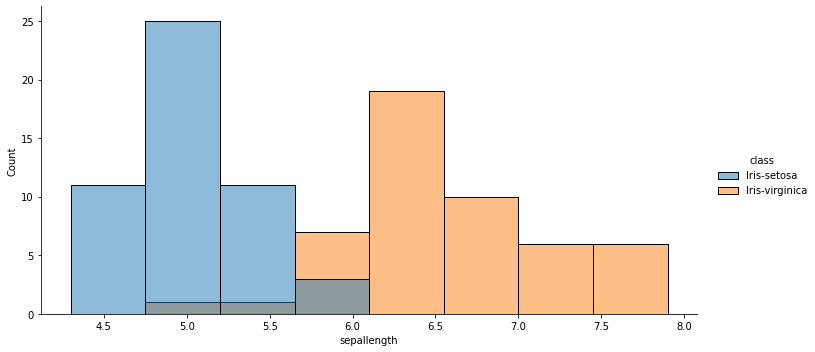

In [6]:
f = sns.displot(data=df_2_class,
x='sepallength',
aspect=2,
hue='class')
f.fig.savefig(Path('./sepal-length-dist.jpg'))

In [7]:
df_2_class.loc[df_2_class['class'] == 'Iris-setosa', 'is_setosa'] = 1
df_2_class.loc[df_2_class['class'] == 'Iris-virginica', 'is_setosa'] =  0
# df_2_class['class'].map({'Iris-setosa':1, 'Iris-virginica':0})

In [8]:
df_2_class.columns

Index(['sepallength', 'sepalwidth', 'petallength', 'petalwidth', 'class',
       'is_setosa'],
      dtype='object')

In [9]:
df_2_class[['sepallength', 'is_setosa']].\
    to_csv(output_dataset,
    header=False,
    sep='|',
    index=False)

## Run Model

In [10]:
cmd = f'dotnet run --project ../model/ ../data/ iris-one-feature.csv'

In [11]:
!{cmd}

Compiling model...done.
Iterating: 
.........|.........|.........|.........|.........| 50
Gaussian(-1,541, 0,163)
Gaussian(2,9, 3,616)


In [12]:
df_results = pd.read_csv(data_dir/'results.csv', sep=';')
df_results

,variable,mean,variance
0,postWeight,-1.541009,0.162996
1,postThreshold,2.899694,3.616315


In [13]:
df_2_class['score'] = df_2_class.sepallength * -2.021

In [14]:
mean = -11.41
var = 0.1953

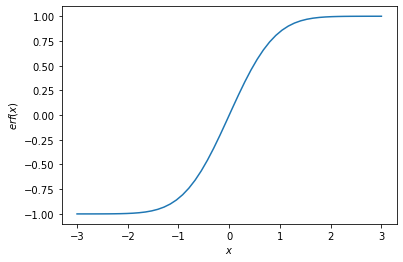

In [15]:
x = np.linspace(-3, 3)
plt.plot(x, special.erf(x))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

In [16]:
x = np.linspace(-20, 0, 1000)

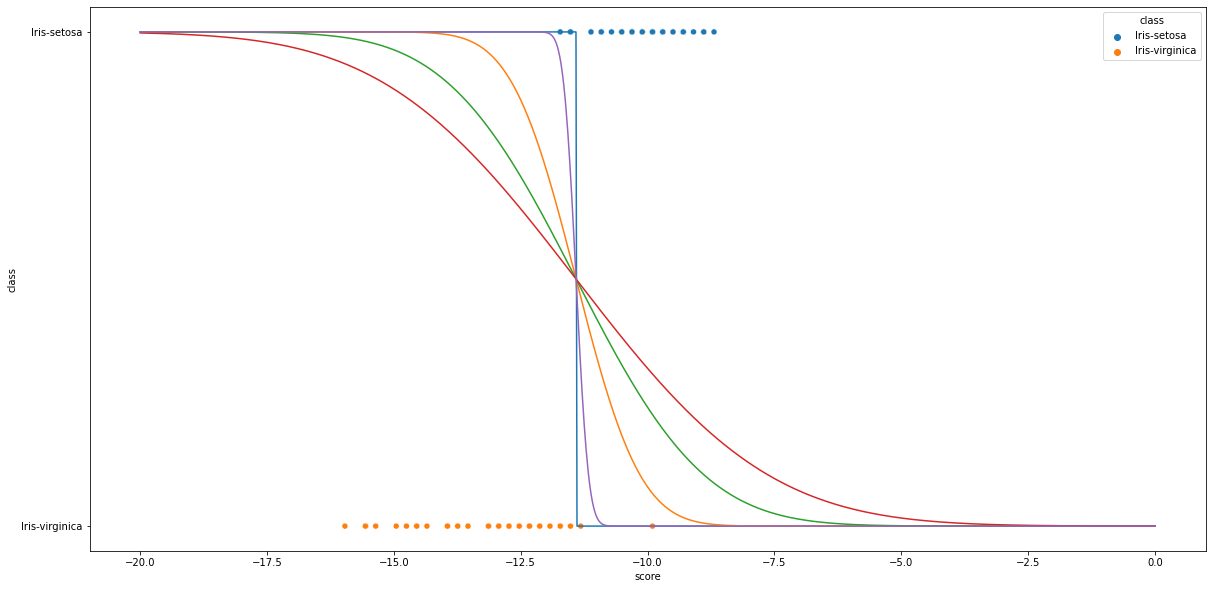

In [17]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_2_class,
x='score', 
y='class', 
hue='class')
for i in [0, 1, 2, 3, var]:
    y = cdf(x, mean, i)
    plt.plot(x,y, label=str(i))

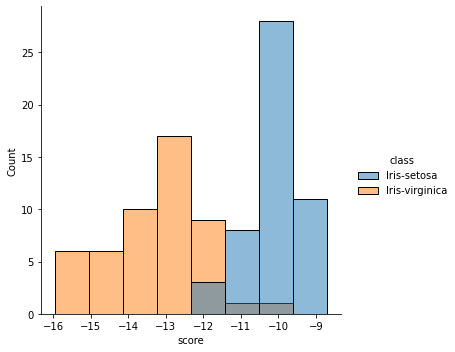

In [18]:
sns.displot(data=df_2_class,
x='score', 
hue='class')